<a href="https://colab.research.google.com/github/Mar-celo/Enap/blob/master/Pipeline_mixto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pipeline para dados heterogêneos: texto e categorias

Mencionamos pipelines para texto e para dados numéricos e categóricos. 
Mas sem demonstração de um pipeline com dados mixtos de múltiplos tipos.

O objeto sklearn que permite um pré-processamento diferenciado por coluna é o `ColumnTransformer`: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

Segue então um exemplo, com os dados das lojas americanas.
https://github.com/b2wdigital/b2w-reviews01

|#|Field|Data type| Description|
|-|-----|:---------|:------------|
|1  |submission_date| date/time |review submission date (format YYYY-MM-DD hh:mm:ss)|
|2  |reviewer_id| string |unique reviewer id|
|3  |product_id| integer |unique product id|
|4  |product_name| string |product name|
|5  |product_brand| string |product brand|
|6  |site_category_lv1| string |product category - first level|
|7  |site_category_lv2| string |product category - second level|
|8  |overall_rating| integer |overall customer rating, from 1 to 5|
|9  |recommend_to_a_friend| string |answer to “would you recommend this product to a friend?” (“Yes”/“No”)|
|10 |review_title| text |review title, introduces or summarizes the review content|
|11 |review_text| text |main text content of the review|
|12 |reviewer_birth_year| integer| reviewer’s birth year|
|13 |reviewer_gender| string |reviewer’s gender (”F” for female; ”M” for male)|
|14 |reviewer_state| string| reviewer’s Brazilian State, according to the delivery address|

Código adaptado de: https://stackoverflow.com/questions/57867974/one-pipeline-to-fit-both-text-and-categorical-features

In [ ]:
import pandas as pd

In [ ]:
# Download do arquivo de dados das Lojas Americanas no GitHub
url = "https://github.com/b2wdigital/b2w-reviews01/raw/master/B2W-Reviews01.csv"

df = pd.read_csv('https://github.com/b2wdigital/b2w-reviews01/raw/master/B2W-Reviews01.csv', sep=';', low_memory=False )

In [ ]:
df

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132368,2018-05-31 23:30:50,15f20e95ff44163f3175aaf67a5ae4a94d5030b409e521...,17962233,Carregador De Pilha Sony + 4 Pilhas Aa 2500mah,NaN,Câmeras e Filmadoras,Acessórios para Câmeras e Filmadoras,Ótimo produto!,5,Yes,"Vale muito, estou usando no controle do Xbox e...",1988.0,M,RS
132369,2018-05-31 23:42:25,def7cf9028b0673ab8bca3b1d06e085461fafb88cd48d9...,132631701,Mop Giratório Fit + Refil Extra - At Home,NaN,Utilidades Domésticas,Material de Limpeza,Sensacional,5,Yes,"Prático e barato, super indico o produto para ...",1979.0,F,SP
132370,2018-05-31 23:44:16,7bcbf542f5d7dd9a9a192a6805adba7a7a4c1ce3bf00df...,16095859,Fita Led 5m Rgb 3528 Siliconada Com 300 Leds C...,NaN,Automotivo,Iluminação,Ótimo produto,4,Yes,Chegou antes do prazo previsto e corresponde a...,1979.0,F,PR
132371,2018-05-31 23:46:48,e6fb0b19277d01c2a300c7837a105f3c369377e92f9c19...,6774907,Etiquetas Jurídicas Vade Mecum - Marca Fácil,marca facil,Papelaria,Material de Escritório,O produto não é bom.,1,No,"Material fraco, poderia ser melhor. Ficou deve...",1991.0,M,RJ


In [ ]:
# Vamos focar em um mix de typos de dados:
# Texto: review_text
# numérico: reviewer_birth_year
# categórico: reviewer_state

# Mais a variável dependente (target): overall_rating (1 a 5)
sub = df[['review_text', 'reviewer_birth_year', 'reviewer_state', 'overall_rating']]

In [ ]:
sub.shape

(132373, 4)

In [ ]:
# Muitos dados, descartamos as linhas com nulos (NaN)
sub = sub.dropna()

In [ ]:
sub.shape

(126389, 4)

In [ ]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126389 entries, 0 to 132372
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   review_text          126389 non-null  object 
 1   reviewer_birth_year  126389 non-null  float64
 2   reviewer_state       126389 non-null  object 
 3   overall_rating       126389 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.8+ MB


In [ ]:
sub.reviewer_birth_year = sub.reviewer_birth_year.map(int)

In [ ]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126389 entries, 0 to 132372
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   review_text          126389 non-null  object
 1   reviewer_birth_year  126389 non-null  int64 
 2   reviewer_state       126389 non-null  object
 3   overall_rating       126389 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ MB


In [ ]:
import numpy as np

In [ ]:
# Discretização simples: negativo com nota de 1 a 3, positivo de 4 a 5
sub['label'] = np.where(sub.overall_rating <= 3, 0, 1)

In [ ]:
sub.drop(['overall_rating'], axis=1, inplace=True)

In [ ]:
sub

,review_text,reviewer_birth_year,reviewer_state,label
0,Estou contente com a compra entrega rápida o ú...,1958,RJ,1
1,"Por apenas R$1994.20,eu consegui comprar esse ...",1996,SC,1
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984,SP,1
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985,SP,1
4,"A entrega foi no prazo, as americanas estão de...",1994,MG,1
...,...,...,...,...
132368,"Vale muito, estou usando no controle do Xbox e...",1988,RS,1
132369,"Prático e barato, super indico o produto para ...",1979,SP,1
132370,Chegou antes do prazo previsto e corresponde a...,1979,PR,1
132371,"Material fraco, poderia ser melhor. Ficou deve...",1991,RJ,0


In [ ]:
# Construção do pipeline diferenciado por tipo de coluna

# Pacotes sklearn
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Detalhes ColumnTransformer: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
preprocessor = ColumnTransformer( 
    transformers=[
        ('text', TfidfVectorizer(), 'review_text'), #TfidfVectorizer accepts column name only between quotes
        ('category', OneHotEncoder(), ['reviewer_state']),
        ('integer', StandardScaler(), ['reviewer_birth_year'])
    ]
)
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000)),
    ],
)

In [ ]:
X = sub[['review_text', 'reviewer_birth_year', 'reviewer_state']]
y = sub['label']

In [ ]:
print(X.shape)
print(y.shape)

(126389, 3)
(126389,)


In [ ]:
# Partição treino/teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
m = pipe.fit(X_train, y_train)

In [ ]:
m.score(X_test, y_test)

0.8710736608908932

In [ ]:
# Representação do pipeline
from sklearn import set_config
set_config()
# set_config(display='diagram')
m

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('text',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                           

In [ ]:
# O pipeline definido anteriormente pode também ser utilizado em uma busca por hiper-parâmetros otimizados
param_grid = {
    'classifier__C': [0.5, 1.0, 2]
}

In [ ]:
grid_search = GridSearchCV(m, param_grid, n_jobs=-1, verbose=1, cv=3)

In [ ]:
grid_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   56.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('text',
                                                                         TfidfVectorizer(analyzer='word',
                                                                                         binary=False,
                                                                                         decode_error='strict',
                                                                                         dtype=<class 'numpy.float64'>,
                              

In [ ]:
grid_search.score(X_test, y_test)

0.8710736608908932

In [ ]:
best = grid_search.best_estimator_.get_params()
best

{'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'classifier__C': 1.0,
 'classifier__class_weight': None,
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 1000,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False,
 'memory': None,
 'preprocessor': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers

In [ ]:
for p in sorted(param_grid.keys()):
    print(f"{p}: {best[p]}")

classifier__C: 1.0


In [ ]:
from sklearn.metrics import plot_confusion_matrix

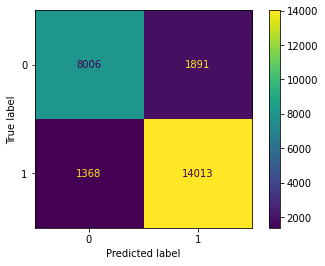

In [ ]:
plot_confusion_matrix(grid_search, X_test, y_test.values.ravel(),values_format='d');